# Attention is All You Need

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

<img src="https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/transformer1.png?raw=1"/>

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future. 

The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

#### Dataset
* src -> English
* trg -> French

#### Embedding
*  input_dim -> vocab_size is the number of words in your train, val and test set
* hid_dim -> embedding_size: each word is map to some dimisional space

* n_layer -> num_layers
* n_heads -> num_heads

* pf_dim -> forward_expansion

#### Perplexity
The lower the perplexity, the more likely the sentence is to sound natural to human ears.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator, TabularDataset
from torchtext.data.metrics import bleu_score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import spacy
import numpy as np

from IPython.display import display, clear_output
from itertools import product
from collections import OrderedDict
from collections import namedtuple

import random
import math
import time
import json
import codecs

spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

## Utils

In [2]:
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def print_terminal(arg: str):
    print(f"========== {arg} ==========\n")

def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print_terminal(f'The model has {params:,} trainable parameters')
    
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    print_terminal(f"Default seed set: {seed}")
    
def model_file_path():
    return './save_models/text_1.pt'

## Inference

In [3]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
    
    if isinstance(sentence, str):
        tokens = tokenize_fr(sentence)
    else:
        tokens = [token.lower() for token in sentence]
        
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    for i in range(max_len):
        
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:], attention

def display_attention(sentence, translation, attention, num_heads=8, num_rows=4, num_cols=2):
    assert num_rows * num_cols == num_heads
    
    fig = plt.figure(figsize=(15,25))
    for i in range(num_heads):
        
        ax = fig.add_subplot(num_rows, num_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
        ax.set_yticklabels(['']+translation)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    plt.show()
    plt.close()
    
def model_test(dataset, src_field, trg_field, model, device, max_len=50):
    example_idx = random.randint(1, len(dataset.examples))
    
    src = vars(dataset.examples[example_idx])['src']
    trg = vars(dataset.examples[example_idx])['trg']

    print_terminal(f'src = {src}') 
    print_terminal(f'trg = {trg}')

    translation, attention = translate_sentence(src, src_field, trg_field, model, device)
    print_terminal(f'predicted trg = {translation}')

    display_attention(src, translation, attention)
    
def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
    return bleu_score(pred_trgs, trgs)

## Seed

In [4]:
set_seed()

========== Default seed set: 1234 ==========



## Bible Data Processing

In [12]:
# bible_english = open('./fr-en/king-james-bible.txt', encoding='utf-8').read().split('\n')
# fr_data = json.load(codecs.open('./fr-en/french_bible.json', 'r', 'utf-8-sig'))

# bible_english = bible_english[:-1]
# french_bible = []
# fr_books_name = fr_data['bible']['booknames'].split(",")

# for books_idx, books in enumerate(fr_data['bible']['b']):
#     en_book_name = books['_n']
#     fr_book_name = fr_books_name[books_idx]
#     for chapter in books['c'] if isinstance(books['c'], (list)) else [books['c']]:
#         for verse in chapter['v']:
#             verse_ = en_book_name + f" {chapter['_n']}:{verse['_n']} \t {verse.get('__text', ' ')} \t {fr_book_name} {chapter['_n']}:{verse['_n']}"
#             french_bible.append(verse_)

# raw_data = {"eng": [ french_bible[index].split('\t')[0] + ' ' + ' '.join([str(elem) for elem in line.split(' ')[2:]]) for index,line in enumerate(bible_english)],
#            "fre": [line.split('\t')[-1] + ' ' + line.split('\t')[1] for index, line in enumerate(french_bible)]}

# data_df = pd.DataFrame(raw_data, columns=['eng','fre'])
# data_df.to_csv('./dataset/eng-fre-bible.csv', index=False)
# data_df.to_json('./dataset/eng-fre-bible.json', orient='records', lines=True)

# _, test_data = train_test_split(data_df, test_size=0.1)
# _, valid_data = train_test_split(data_df, test_size=0.1)
# test_data.to_json('./dataset/eng-fre-bible-test.json', orient='records', lines=True)
# test_data.to_json('./dataset/eng-fre-bible-valid.json', orient='records', lines=True)
# data_df.head()

In [5]:
SOURCE = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)
TARGET = Field(tokenize=tokenize_fr, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

fields = {'eng': ('src', SOURCE), 'fre': ('trg', TARGET)}

train_data, test_data, valid_data = TabularDataset.splits(
    path='./final_data/',
    train='eng_fre_train.json',
    test='eng_fre_test.json',
    validation='eng_fre_valid.json',
    format='json',
    fields=fields)

/home/real-music/anaconda3/envs/ray/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/real-music/anaconda3/envs/ray/lib/python3.7/site-packages/torchtext/data/example.py:13: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [14]:
len(train_data)

52486

In [15]:
print(vars(train_data.examples[0]))

{'src': ['genesis', '1:1', ' ', 'in', 'the', 'beginning', 'god', 'created', 'the', 'heaven', 'and', 'the', 'earth', '.'], 'trg': [' ', 'genèse', '1:1', ' ', 'au', 'commencement', 'dieu', 'créa', 'les', 'cieux', 'et', 'la', 'terre', '.']}


In [16]:
print(vars(train_data.examples[1]))

{'src': ['genesis', '1:2', ' ', 'and', 'the', 'earth', 'was', 'without', 'form', ',', 'and', 'void', ';', 'and', 'darkness', '[', 'was', ']', 'upon', 'the', 'face', 'of', 'the', 'deep', '.', 'and', 'the', 'spirit', 'of', 'god', 'moved', 'upon', 'the', 'face', 'of', 'the', 'waters', '.'], 'trg': [' ', 'genèse', '1:2', ' ', 'et', 'la', 'terre', 'était', 'désolation', 'et', 'vide', ',', 'et', 'il', 'y', 'avait', 'des', 'ténèbres', 'sur', 'la', 'face', 'de', "l'", 'abîme', '.', 'et', "l'", 'esprit', 'de', 'dieu', 'planait', 'sur', 'la', 'face', 'des', 'eaux', '.']}


In [6]:
SOURCE.build_vocab(train_data, min_freq=2)
TARGET.build_vocab(train_data, min_freq=2)

In [18]:
# Read text file
# english_txt = open('./fr-en/europarl-v7.fr-en.en', encoding='utf-8').read().split('\n')
# french_txt = open('./fr-en/europarl-v7.fr-en.fr', encoding='utf-8').read().split('\n')

# print_terminal(f"We have about {len(english_txt):,} sentence in out dataset.")
# raw_data = {'English': [line for line in english_txt],
#            "French": [line for line in french_txt]}

# # Convert to dataframe
# data_df = pd.DataFrame(raw_data, columns=['English', 'French'])
# data_df.head()

# # Split data 50% training, 25% testing and 25% validation
# train_data, test_data = train_test_split(data_df, test_size=0.25)
# train_data, valid_data = train_test_split(train_data, test_size=0.25)

# print_terminal(f"Train size: {len(train_data):,}")
# print_terminal(f"Test size: {len(test_data):,}")
# print_terminal(f"Valid size: {len(valid_data):,}")

# dump csv data
# train_data.to_csv('./dataset/train.csv', index=False)
# test_data.to_csv('./dataset/test.csv', index=False)
# valid_data.to_csv('./dataset/valid.csv', index=False)
# print_terminal("Done writing [CVS]")

# dump csv json
# train_data.to_json('./dataset/train.json', orient='records', lines=True)
# test_data.to_json('./dataset/test.json', orient='records', lines=True)
# valid_data.to_json('./dataset/valid.json', orient='records', lines=True)
# print_terminal("Done writing [JSON]")

# SOURCE = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)
# TARGET = Field(tokenize=tokenize_fr, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

# fields = {'English': ('src', SOURCE), 'French': ('trg', TARGET)}

# train_data, test_data, valid_data = TabularDataset.splits(
#     path='./dataset/',
#     train='train.json',
#     test='test.json',
#     validation='valid.json',
#     format='json',
#     fields=fields)

In [19]:
# print(vars(train_data.examples[0]))

In [20]:
# SOURCE.build_vocab(train_data, min_freq=2)
# TARGET.build_vocab(train_data, min_freq=2)

In [21]:
# train_iterator, test_iterator, valid_iterator = BucketIterator.splits(
#     (train_data, test_data, valid_data),
#     batch_size=1000,
#     shuffle=True,
#     sort_key=lambda x: len(x.src),
#     sort_within_batch=True,
#     device = 'cuda')

In [22]:
# for batch in train_iterator:
#     print(batch.src)
#     break

## Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_size, 
                 num_layers, 
                 num_heads, 
                 forward_expansion,
                 dropout, 
                 device,
                 max_length = 100):
        
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(vocab_size, embedding_size)
        self.pos_embedding = nn.Embedding(max_length, embedding_size)
        
        self.layers = nn.ModuleList([EncoderLayer(embedding_size, 
                                                  num_heads, 
                                                  forward_expansion,
                                                  dropout, 
                                                  device) 
                                     for _ in range(num_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([embedding_size])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch_size, src_len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]
        
#         print_terminal(src.shape)
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src = [batch size, src len, embedding_size]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, embedding_size]
        return src

## Encoder Layer

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, embedding_size, num_heads, forward_expansion, dropout, device):
        super(EncoderLayer, self).__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(embedding_size)
        self.ff_layer_norm = nn.LayerNorm(embedding_size)
        self.self_attention = MultiHeadAttentionLayer(embedding_size, num_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(embedding_size, forward_expansion, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, embedding_size]
        #src_mask = [batch size, 1, 1, src len] 
        
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, embedding_size]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, embedding_size]
        
        return src

## Mutli Head Attention Layer

In [9]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, embedding_size, num_heads, dropout, device):
        super().__init__()
        
        assert embedding_size % num_heads == 0
        
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.head_dim = embedding_size // num_heads
        
        self.fc_q = nn.Linear(embedding_size, embedding_size)
        self.fc_k = nn.Linear(embedding_size, embedding_size)
        self.fc_v = nn.Linear(embedding_size, embedding_size)
        
        self.fc_o = nn.Linear(embedding_size, embedding_size)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.embedding_size)
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]
        
        return x, attention

## Position-wise Feedforward Layer

In [10]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, embedding_size, forward_expansion, dropout):
        super(PositionwiseFeedforwardLayer, self).__init__()
        
        self.fc_1 = nn.Linear(embedding_size, forward_expansion)
        self.fc_2 = nn.Linear(forward_expansion, embedding_size)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, seq len, hid dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        return x

## Decoder

In [11]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 embedding_size, 
                 num_layers, 
                 num_heads, 
                 forward_expansion,
                 dropout,
                 device,
                 max_length=100):
        super(Decoder, self).__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, embedding_size)
        self.pos_embedding = nn.Embedding(max_length, embedding_size)
        self.layers = nn.ModuleList([DecoderLayer(embedding_size, 
                                                  num_heads, 
                                                  forward_expansion, 
                                                  dropout, 
                                                  device)
                                     for _ in range(num_layers)])
        
        self.fc_out = nn.Linear(embedding_size, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([embedding_size])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0 , trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
              
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]
        
        return output, attention

## Decoder Layer

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 embedding_size, 
                 num_heads, 
                 forward_expansion, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(embedding_size)
        self.enc_attn_layer_norm = nn.LayerNorm(embedding_size)
        self.ff_layer_norm = nn.LayerNorm(embedding_size)
        self.self_attention = MultiHeadAttentionLayer(embedding_size, num_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(embedding_size, num_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(embedding_size, 
                                                                     forward_expansion, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

## Seq2Seq Model

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Train Model

In [31]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        
        Run = namedtuple("Run", params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
            
        return runs
    
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_start_time = 0
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.valid_loss = 0
        self.valid_iterator = None
        
        self.test_loss = 0
        self.test_iterator = None
        
        self.best_params = OrderedDict()
        
        self.model = None
        self.optimizer = None
        self.iterator = None
    
    def begin_run(self, run, model, optimizer, iterator, valid_iterator, test_iterator):
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        
        self.model = model
        self.optimizer = optimizer
        self.iterator = iterator
        self.valid_iterator = valid_iterator
        self.test_iterator = test_iterator
        
    def end_run(self):
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.valid_loss = 0
        self.test_loss = 0

    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.iterator)
        valid_loss = self.valid_loss / len(self.valid_iterator)
        test_loss = self.test_loss / len(self.test_iterator)
        
        results = OrderedDict()
        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        
        results['train loss'] = loss
        results['valid loss'] = valid_loss
        results['test loss'] = test_loss
        
        results['train perplexity'] = f'{math.exp(loss)}'
        results['valid perplexity'] = f'{math.exp(valid_loss)}'
        results['test perplexity'] = f'{math.exp(test_loss)}'
        
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        
        clear_output(wait=True)
        display(df)
        
    def track_loss(self, loss):
        self.epoch_loss += loss.item()
        
    def track_valid_loss(self, loss):
        self.valid_loss += loss.item()
        
    def track_test_loss(self, loss):
        self.test_loss += loss.item()
        
    def save(self, fileName):
        pd.DataFrame.from_dict(
        self.run_data, 
        orient='columns').to_csv(f'./final_data/{fileName}.csv')
        
        with open(f'./final_data/{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)
            
    def get_best_params(self, parameters: OrderedDict, num_to_display=5):

        df = pd.read_csv('./final_data/results.csv')
        df = df.drop(columns='Unnamed: 0', axis=1)
        df = df.sort_values(['train loss', 'train perplexity'])
        
        new_params = df.head(1).to_dict('records')
        for idx , key in enumerate(parameters):
            
            if key in new_params[0]:
                parameters[key] = [new_params[0][key]]
                
        self.best_params = parameters
        
        clear_output(wait=True)
        print_terminal(f'Best params: {self.best_params}')
        display(df.head(num_to_display))
        
    def train_with_best_params(self):
        for run in RunBuilder.get_runs(self.best_params):
            print_terminal(f"Training with best params: {self.best_params}")
            
            encoder = Encoder(src_vocab_size, embedding_size, num_encoder_layers, num_heads, forward_expansion, dropout, device)
            decoder = Decoder(trg_vocab_size, embedding_size, num_decoder_layers, num_heads, forward_expansion, dropout, device)

            model = Seq2Seq(encoder, decoder, src_pad_idx, trg_pad_idx, device).to(device)
            model.apply(initialize_weights)

            train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
                (train_data, valid_data, test_data),
                batch_size=run.batch_size,
                shuffle=run.shuffle,
                sort_within_batch=True,
                sort_key=lambda x: len(x.src),
                device = device)

            optimizer = torch.optim.Adam(model.parameters(), lr=run.lr)
            criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)
            
            best_valid_loss = float('inf')
            
            self.begin_run(run, model, optimizer, train_iterator, valid_iterator, test_iterator)
            for epoch in range(num_epochs):
                self.begin_epoch()

                self.train_model(train_iterator, model, optimizer, criterion, clip, m)

                self.end_epoch()
            self.end_run()
        self.save_checkpoint("seq2seq-bible")
        
    
    def save_checkpoint(self, filename='checkpoint'):
        print_terminal("=> Saving checkpoint")
        checkpoint = {
            "state_dict": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
        }
        
        torch.save(checkpoint, f'./checkpoints/{filename}.pt')
        print_terminal(f"=> Done saving. Filename: {filename}")

    def load_checkpoint(self, model, filename='checkpoint'):
        print_terminal("=> Loading checkpoint")
        
        checkpoint = torch.load(f"./checkpoints/{filename}.pt")
        if model: model.load_state_dict(checkpoint["state_dict"])
        else: self.model.load_state_dict(checkpoint["state_dict"])
        
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        
        print_terminal(f"=> Done loading {filename}")
        return model if model else self.model
            
    @staticmethod
    def evaluate_model(iterator, model, criterion, m, test=False):
        model.eval()
        with torch.no_grad():
            for batch in iterator:

                src = batch.src
                trg = batch.trg

                output, _ = model(src, trg[:,:-1])
                #output = [batch size, trg len - 1, output dim]
                #trg = [batch size, trg len]

                output_dim = output.shape[-1]

                output = output.contiguous().view(-1, output_dim)
                trg = trg[:,1:].contiguous().view(-1)
                #output = [batch size * trg len - 1, output dim]
                #trg = [batch size * trg len - 1]

                loss = criterion(output, trg)
                if test:
                    m.track_valid_loss(loss) # valid_loss += loss.item()
                m.track_test_loss(loss) # valid_loss += loss.item()
            
    @staticmethod
    def train_model(iterator, model, optimizer, criterion, clip, m):
        model.train()
        for batch in iterator:

            src = batch.src.to(device)
            trg = batch.trg.to(device)

            output, _ = model(src, trg[:,:-1])
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            optimizer.zero_grad()
            loss = criterion(output, trg) # calculation gradient
            loss.backward() # Update weights

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            m.track_loss(loss) # epoch_loss += loss.item()

## Training Params

In [32]:
# Setup the training phase
device = torch.device('cpu' if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

# Training hyperparameters
num_epochs = 20
learning_rate = 0.0005
batch_size = 128

# Model hyperparameters
src_vocab_size = len(SOURCE.vocab)
trg_vocab_size = len(TARGET.vocab)
embedding_size = 256
num_encoder_layers = 3
num_decoder_layers = 3
num_heads = 8
forward_expansion = 512
dropout = 0.1
max_len = 500
src_pad_idx = SOURCE.vocab.stoi[SOURCE.pad_token]
trg_pad_idx = TARGET.vocab.stoi[TARGET.pad_token]
clip = 1

print(src_vocab_size, trg_vocab_size)
m = RunManager()

18158 24416


## Initialize Training with Hyperparams

In [ ]:
parameters = OrderedDict(
    lr = [.0005],
    batch_size = [32],
    shuffle = [True],
    epochs = [300]
)

m = RunManager()
for run in RunBuilder.get_runs(parameters):
    print_terminal(f"-{run}")

    encoder = Encoder(src_vocab_size, embedding_size, num_encoder_layers, num_heads, forward_expansion, dropout, device, max_len)
    decoder = Decoder(trg_vocab_size, embedding_size, num_decoder_layers, num_heads, forward_expansion, dropout, device, max_len)

    model = Seq2Seq(encoder, decoder, src_pad_idx, trg_pad_idx, device).to(device)
    model.apply(initialize_weights)

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=run.batch_size,
        shuffle=run.shuffle,
        sort_within_batch=True,
        sort_key=lambda x: len(x.src),
        device = device)

    optimizer = torch.optim.Adam(model.parameters(), lr=run.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

#     best_valid_loss = float('inf')

#     m.begin_run(run, model, optimizer, train_iterator, valid_iterator, test_iterator)
#     for epoch in range(run.epochs):
#         m.begin_epoch()

#         m.train_model(train_iterator, model, optimizer, criterion, clip, m)
#         m.evaluate_model(valid_iterator, model, criterion, m)
#         m.evaluate_model(test_iterator, model, criterion, m)
        
#         m.end_epoch()
#     m.end_run()
# m.save('eng-fre-results')

,run,epoch,train loss,valid loss,test loss,train perplexity,valid perplexity,test perplexity,epoch duration,run duration,lr,batch_size,shuffle,epochs
0,1,1,4.420139,0.0,0.0,83.10784980963739,1.0,1.0,1057.596509,1057.596515,0.0005,32,True,300


/home/real-music/anaconda3/envs/ray/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Best Hyperparams with low loss and low perplexity

In [ ]:
m.get_best_params(parameters)

## Save model with best params

In [ ]:
m.train_with_best_params()

## Evaluate Model

In [ ]:
# model = m.load_checkpoint()
# m.evaluate_model(m.test_iterator, model, criterion, m)

## Model BLEU

In [ ]:
# blue_score = calculate_bleu(test_data, SOURCE, TARGET, model, device, max_len)
# print_terminal(f'BLEU score = {blue_score*100:.2f}')

In [33]:
encoder = Encoder(src_vocab_size, embedding_size, num_encoder_layers, num_heads, forward_expansion, dropout, device, max_len)
decoder = Decoder(trg_vocab_size, embedding_size, num_decoder_layers, num_heads, forward_expansion, dropout, device, max_len)

model = Seq2Seq(encoder, decoder, src_pad_idx, trg_pad_idx, device).to(device)
model = m.load_checkpoint(model=model, filename="eng-fre-checkpoint")

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

========== => Loading checkpoint ==========



RuntimeError: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for encoder.tok_embedding.weight: copying a param with shape torch.Size([29284, 256]) from checkpoint, the shape in current model is torch.Size([18158, 256]).
	size mismatch for decoder.tok_embedding.weight: copying a param with shape torch.Size([40134, 256]) from checkpoint, the shape in current model is torch.Size([24416, 256]).
	size mismatch for decoder.fc_out.weight: copying a param with shape torch.Size([40134, 256]) from checkpoint, the shape in current model is torch.Size([24416, 256]).
	size mismatch for decoder.fc_out.bias: copying a param with shape torch.Size([40134]) from checkpoint, the shape in current model is torch.Size([24416]).

# Example From Training Set

========== src = ['2', 'corinthians', '5:7', ' ', '(', 'for', 'we', 'walk', 'by', 'faith', ',', 'not', 'by', 'sight', ':', ')'] ==========

========== trg = [' ', '2', 'corinthiens', '5:7', ' ', 'car', 'nous', 'marchons', 'par', 'la', 'foi', ',', 'non', 'par', 'la', 'vue', ';'] ==========

========== predicted trg = ['continuelle', 'généreuse', 'palestinienne', 'adhérents', 'méditerranée', 'évitons', 'paraboles', '2:10', 'style', '25:45', 'merveilleuses', 'fixa', 'chargement', 'mince', '23:12', '50:18', '39:18', '-ou', 'traitements', 'fatiguez', 'finis', 'fosse', 'empara', 'infections', 'extractives', 'pertes', 'racines', 'assume', 'ashères', 'séjourné', 'existence', 'shinhar', 'présentèrent', 'martinez', 'initiatives', 'chassent', 'dommageable', '29:26', 'frémirent', 'insistons', 'comparaison', 'leadership', 'dalits', 'mourir', 'doctrines', '26:14', 'makhlon', 'menait', 'grappilleras', 'populaire'] ==========



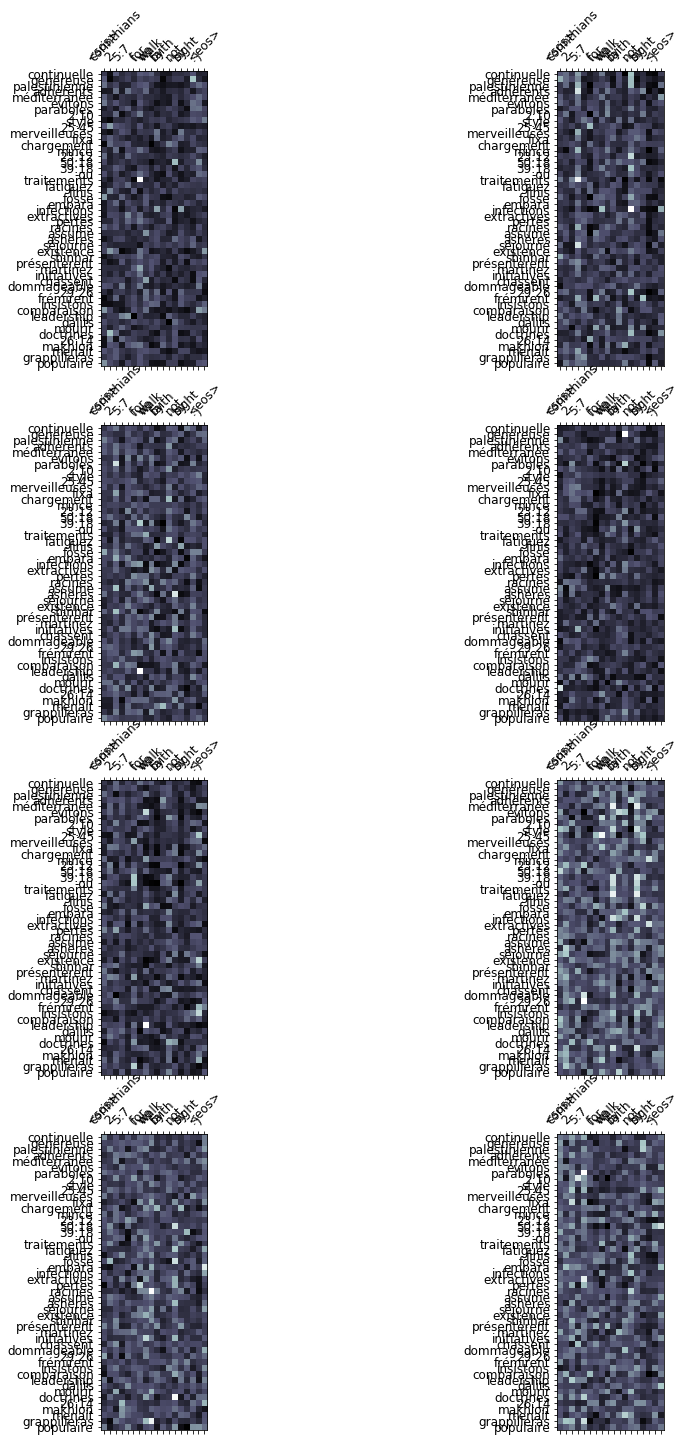

In [20]:
model_test(train_data, SOURCE, TARGET, model, device, max_len)

## Example From Validation Set

In [ ]:
# model_test(valid_data, SOURCE, TARGET, model, device, max_len)

## Example From Testing Set

In [ ]:
# model_test(test_data, SOURCE, TARGET, model, device, max_len)